In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

In [2]:
import numpy as np 
import scipy.fft
import scipy.integrate
from operators.SW_sqrt import psi_ln_sw
from operators.SW import solve_poisson_equation_two_stream, total_mass, total_momentum, total_energy_k

In [17]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.pylab as pl
font = {'family' : 'serif',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

# Two-Stream Instability SW

In [4]:
# set up configuration parameters
# number of mesh points in x
Nx = 101
# number of spectral expansions
Nv = 100
# epsilon displacement in initial electron distribution
epsilon = 1e-3
# velocity scaling of electron and ion
alpha_e1 = 0.5 / np.sqrt(2)
alpha_e2 = 0.5 / np.sqrt(2)
alpha_i = np.sqrt(1 / 1863)
# x grid is from 0 to L
L = 2 * np.pi
# spacial spacing dx = x[i+1] - x[i]
dx = L / (Nx - 1)
# final time
T = 45
# velocity scaling
u_e1 = 1
u_e2 = -1
u_i = 0
# mass normalized
m_e1 = 1
m_e2 = 1
m_i = 1863
# charge normalized
q_e1 = -1
q_e2 = -1
q_i = 1

In [5]:
# velocity grid for plotting purposes
v = np.linspace(-3, 3, int(1e5))
# spatial grid 
x = np.linspace(0, L, Nx)

In [6]:
# initial condition of the first expansion coefficient
C_0e1 = 0.5 * (1 / (np.sqrt(2 * np.sqrt(np.pi)))) * (1 + epsilon * np.cos(x)) / alpha_e1
C_0e2 = 0.5 * (1 / (np.sqrt(2 * np.sqrt(np.pi)))) * (1 + epsilon * np.cos(x)) / alpha_e2
C_0i = (1 / (np.sqrt(2 * np.sqrt(np.pi)))) * np.ones(Nx) / alpha_i

In [7]:
# the distribution function of electrons and protons for plotting purposes
f_0e1 = np.outer(C_0e1, psi_ln_sw((v-u_e1)/alpha_e1, n=0))
f_0e2 = np.outer(C_0e2, psi_ln_sw((v-u_e2)/alpha_e2, n=0))
f_0i = np.outer(C_0i, psi_ln_sw((v-u_i)/alpha_i, n=0))

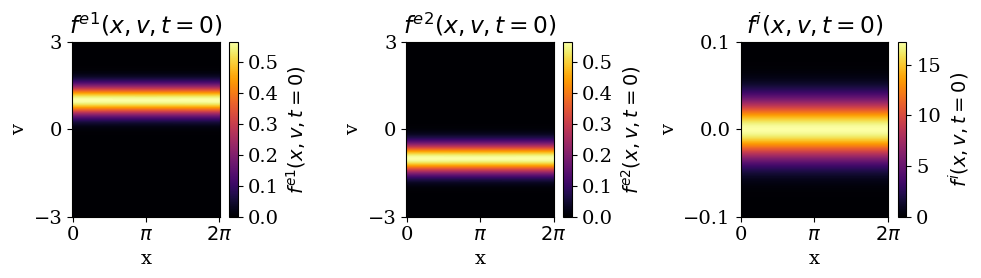

In [8]:
fig, ax = plt.subplots(ncols=3, sharey=False, figsize=(10, 3))
pos = ax[0].pcolormesh(x, v, f_0e1.T, cmap="inferno", vmin=0, vmax=np.max(f_0e1))
ax[0].set_xlabel("x")
ax[0].set_xticks([0, np.pi, 2*np.pi])
ax[0].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[0].set_ylabel("v")
ax[0].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.ax.set_ylabel('$f^{e1}(x, v, t=0)$', rotation=90)
ax[0].set_title("$f^{e1}(x, v, t=0)$")

pos = ax[1].pcolormesh(x, v, f_0e2.T, cmap="inferno", vmin=0, vmax=np.max(f_0e1))
ax[1].set_xticks([0, np.pi, 2*np.pi])
ax[1].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[1].set_xlabel("x")
ax[1].set_ylabel("v")
ax[1].set_yticks([-3, 0, 3])
cbar = fig.colorbar(pos)
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
cbar.ax.set_ylabel('$f^{e2}(x, v, t=0)$', rotation=90)
ax[1].set_title("$f^{e2}(x, v, t=0)$")

pos = ax[2].pcolormesh(x, v, f_0i.T, cmap="inferno")
ax[2].set_xticks([0, np.pi, 2*np.pi])
ax[2].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax[2].set_xlabel("x")
ax[2].set_ylabel("v")
ax[2].set_yticks([-0.1, 0, 0.1])
ax[2].set_ylim(-0.1, 0.1)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{i}(x, v, t=0)$', rotation=90)
ax[2].set_title("$f^{i}(x, v, t=0)$")

plt.tight_layout()
plt.savefig("../figs/SW/two_stream/initial_condition_two_stream.png", dpi=600)

In [9]:
# load the simulation results
sol_midpoint_u = np.load("../data/SW/two_stream/sol_midpoint_u_" + str(Nv) + ".npy", allow_pickle=True)
sol_midpoint_t = np.load("../data/SW/two_stream/sol_midpoint_t_" + str(Nv) + ".npy", allow_pickle=True)

# print simulation dimensions
print(np.shape(sol_midpoint_u))
print(np.shape(sol_midpoint_t))

(20005, 4500)
(4500,)


In [10]:
# initialize the electric potential
E_midpoint = np.zeros((Nx-1, len(sol_midpoint_t)))

In [11]:
# initialize the states for implicit midpoint (symplectic)
state_e1_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_e2_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))
state_i_midpoint = np.zeros((Nv, Nx-1, len(sol_midpoint_t)))

for ii in range(len(sol_midpoint_t)):
    print("time = ", sol_midpoint_t[ii])
    for jj in range(Nv):
        # unwind the flattening in order to solve the Vlasov-Poisson system
        state_e1_midpoint[jj, :, ii] = sol_midpoint_u[jj*(Nx-1): (jj+1)*(Nx-1), ii]
        state_e2_midpoint[jj, :, ii] = sol_midpoint_u[Nv*(Nx-1) + jj*(Nx-1): Nv*(Nx-1) + (jj+1)*(Nx-1), ii]
        # static/background ions
        state_i_midpoint[0, :, ii] = (1 / (np.sqrt(2 * np.sqrt(np.pi)))) * np.ones(Nx - 1) / alpha_i
    
    E_midpoint[:, ii] = solve_poisson_equation_two_stream(state_e1=state_e1_midpoint[:, :, ii],
                                                          state_e2=state_e2_midpoint[:, :, ii],
                                                          state_i=state_i_midpoint[:, :, ii],
                                                          alpha_e1=alpha_e1,
                                                          alpha_e2=alpha_e2,
                                                          alpha_i=alpha_i, 
                                                          dx=dx, 
                                                          Nx=Nx-1, 
                                                          Nv=Nv, 
                                                          solver="gmres", 
                                                          order_fd=2, L=L)

time =  0.0
time =  0.010002222716159146
time =  0.02000444543231829
time =  0.03000666814847744
time =  0.04000889086463658
time =  0.05001111358079573
time =  0.06001333629695488
time =  0.07001555901311401
time =  0.08001778172927317
time =  0.09002000444543232
time =  0.10002222716159145
time =  0.1100244498777506
time =  0.12002667259390976
time =  0.1300288953100689
time =  0.14003111802622803
time =  0.1500333407423872
time =  0.16003556345854633
time =  0.17003778617470547
time =  0.18004000889086463
time =  0.19004223160702377
time =  0.2000444543231829
time =  0.21004667703934207
time =  0.2200488997555012
time =  0.23005112247166035
time =  0.2400533451878195
time =  0.25005556790397865
time =  0.2600577906201378
time =  0.2700600133362969
time =  0.28006223605245606
time =  0.29006445876861525
time =  0.3000666814847744
time =  0.3100689042009335
time =  0.32007112691709266
time =  0.3300733496332518
time =  0.34007557234941094
time =  0.3500777950655701
time =  0.360080017

In [13]:
# save the electric field
np.save("../data/SW/two_stream/sol_midpoint_e_" + str(Nv) + ".npy", E_midpoint)

In [14]:
# compute the electric field k=1 mode amplitude using fft
E1_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(len(sol_midpoint_t)):
    E1_midpoint[ii] = np.abs(scipy.fft.fft(E_midpoint[:, ii]))[1]

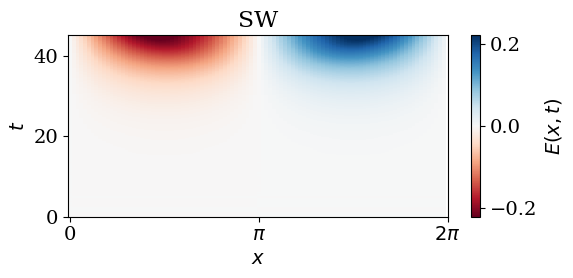

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
pos = ax.pcolormesh(x[:-1], sol_midpoint_t, E_midpoint.T, cmap="RdBu", vmin=-0.22, vmax=0.22)
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel("$E(x, t)$", rotation=90)
ax.set_title("SW")
ax.set_xlabel("$x$")
_ = ax.set_xticks([0, np.pi, 2*np.pi])
_ = ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
_ = ax.set_ylabel("$t$")
plt.tight_layout()
plt.savefig("../figs/SW/two_stream/two_stream_electric_field.png", dpi=600)

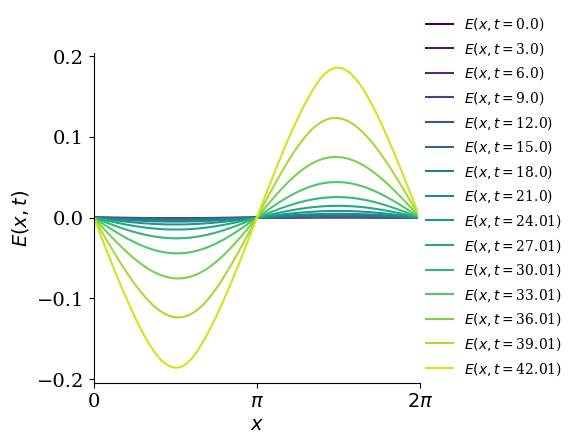

In [18]:
fig, ax = plt.subplots(figsize=(6, 4.5))
colors = pl.cm.viridis(np.linspace(0,1,len(sol_midpoint_t)//300 + 1))

for kk, ii in enumerate(range(0, len(sol_midpoint_t), 300)):
    _ = plt.plot(x[:-1], E_midpoint[:, ii], c=colors[kk], label=r"$E(x, t=$" + str(round(sol_midpoint_t[ii], 2)) + ")")
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=10, loc=(1, 0))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
legend.get_frame().set_alpha(0)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xlim(0, 2*np.pi)
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax.set_xlabel("$x$")
ax.set_ylabel("$E(x, t)$")
plt.tight_layout()

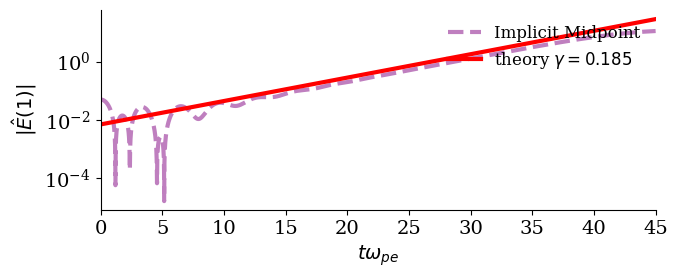

In [23]:
# plot the electric field growth rate
fig, ax = plt.subplots(figsize=(7, 3))
ax.plot(sol_midpoint_t, E1_midpoint, "--", c="purple", alpha=0.5, linewidth=3, label="Implicit Midpoint") 
ax.plot(sol_midpoint_t, np.exp(0.185*sol_midpoint_t)*(7e-3), linewidth=3, color="red", label=r"theory $\gamma = 0.185$")  

ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("$|\hat{E}(1)|$")
ax.set_xlabel("$ t \omega_{pe}$")
ax.set_xlim(0, T)
legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc='upper right')
legend.get_frame().set_alpha(0)
plt.tight_layout()
plt.savefig("../figs/SW/two_stream/electric_field_damping_rate_" + str(Nv) + ".png", dpi=600)

NameError: name 'mcp' is not defined

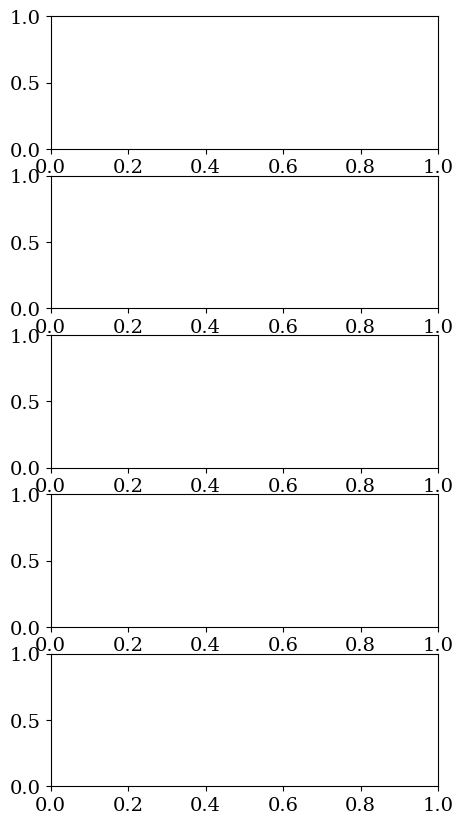

In [24]:
# plot the phase space evolution as a function of time
fig, ax = plt.subplots(nrows=5, figsize=(5, 10))
for tt, ii in enumerate(range(0, 400, int(len(sol_midpoint_t)/5))):
    distribution = np.zeros((Nx, len(v)))
    for jj in range(Nv):
        distribution += np.outer(np.append(state_e2_midpoint[jj, :, ii], state_e2_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e2)/alpha_e2, n=jj))+ np.outer(np.append(state_e1_midpoint[jj, :, ii], state_e1_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e1)/alpha_e1, n=jj))
    levels = np.append(-0.1, np.linspace(0, 0.6, 15))
    colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
    pos = ax[tt].contourf(x, v, (distribution).T, levels=levels, colors=np.append(["w"], colors))
    ax[tt].set_xlabel("x")
    ax[tt].set_xticks([0, np.pi, 2*np.pi])
    ax[tt].set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
    ax[tt].set_ylabel("v")
    cbar = fig.colorbar(pos)
    cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(round(sol_midpoint_t[ii], 2)) + ")", rotation=90)
    ax[tt].set_title("$f^{e}(x, v, t=$" + str(round(sol_midpoint_t[ii], 2)) + ")")
plt.tight_layout()
plt.savefig("../figs/SW/two_stream/two_stream_evolution_" + str(Nv) + ".png", dpi=600)

In [ ]:
# plot the phase space evolution at the final timestamp
fig, ax = plt.subplots(figsize=(6, 3))
ii = -1
distribution = np.zeros((Nx, len(v)))
for jj in range(Nv):
    distribution += np.outer(np.append(state_e2_midpoint[jj, :, ii], state_e2_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e2)/alpha_e2, n=jj))+ np.outer(np.append(state_e1_midpoint[jj, :, ii], state_e1_midpoint[jj, 0, ii]), psi_ln_sw((v-u_e1)/alpha_e1, n=jj))
levels = np.append(-0.1, np.linspace(0, 0.65, 15))
colors = mcp.gen_color(cmap="inferno",n=len(levels)-1)
pos = ax.contourf(x, v, (distribution).T, levels=levels, colors=np.append(["w"], colors))
ax.set_xlabel("x")
ax.set_ylim(-3, 3)
ax.set_xticks([0, np.pi, 2*np.pi])
ax.set_xticklabels([r"0", r"$\pi$", r"$2\pi$"])
ax.set_ylabel("v")
cbar = fig.colorbar(pos)
cbar.ax.set_ylabel('$f^{e}(x, v, t=$' + str(sol_midpoint_t[ii]) + ")", rotation=90)
cbar.ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

plt.tight_layout()
plt.savefig("../figs/SW/two_stream/two_stream_electron_distribution_t_45_SW.png", dpi=600)

In [ ]:
# distribution_sw_sqrt = np.load("../data/SW_sqrt/two_stream/poisson/distribution_45_Nv_100.npy")

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 3))
# _ = ax.plot(v, distribution_sw_sqrt[Nx//4, :], c="red", ls="-", linewidth=2, alpha=1, label="SW square-root")
# _ = ax.plot(v, distribution[Nx//4, :], c="blue", ls="--", linewidth=2, alpha=0.8, label="SW")
# _ = ax.set_xlim(-3, 3)
# _ = ax.set_xlabel("$v$")
# _ = ax.set_ylabel(r"$f^e(x=\frac{\pi}{4}, v, t=45)$")
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# legend = ax.legend(ncols=1, fancybox=False, shadow=False, fontsize=12, loc="upper left")
# legend.get_frame().set_alpha(0)
# ax.set_ylim(-0.05, 0.77)
# plt.tight_layout()
# plt.savefig("../figs/SW/two_stream/poisson/two_stream_filamentation.png", dpi=600)

# conservation laws: mass, momentum, and energy

### mass conservation

In [ ]:
# compute mass conservation
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv)\
                       +total_mass(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv)\
                       +total_mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv)

In [ ]:
# compute mass conservation
mass_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    mass_midpoint[ii] = total_mass(state=state_e_midpoint[:, :, ii], alpha_s=alpha_e, dx=dx, Nv=Nv)\
                       +total_mass(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv)

### momentum conservation

In [ ]:
# compute momentum conservation
momentum_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    momentum_midpoint[ii] = total_momentum(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv, m_s=m_e1, u_s=u_e1)\
                           +total_momentum(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv, m_s=m_e2, u_s=u_e2)\
                           +total_momentum(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, m_s=m_i, u_s=u_i)

In [ ]:
# plot momentum conservation
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(sol_midpoint_t, np.abs(momentum_midpoint - momentum_midpoint[0]), "-")
ax.set_yscale("log")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|P_{mech}(t)-P_{mech}(t=0)|$", fontsize=15)
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
plt.tight_layout()

### energy conservation

In [ ]:
# compute energy (kinetic + potential)
energy_k_midpoint = np.zeros(len(sol_midpoint_t))
energy_p_midpoint = np.zeros(len(sol_midpoint_t))

for ii in range(0, len(sol_midpoint_t)):
    energy_k_midpoint[ii] = total_energy_k(state=state_e1_midpoint[:, :, ii], alpha_s=alpha_e1, dx=dx, Nv=Nv, m_s=m_e1, u_s=u_e1)\
                           +total_energy_k(state=state_e2_midpoint[:, :, ii], alpha_s=alpha_e2, dx=dx, Nv=Nv, m_s=m_e2, u_s=u_e2)\
                           +total_energy_k(state=state_i_midpoint[:, :, ii], alpha_s=alpha_i, dx=dx, Nv=Nv, m_s=m_i, u_s=u_i)
    
    energy_p_midpoint[ii] = 0.5*dx*np.sum((E_midpoint[:, ii])**2)

In [ ]:
# plot energy conservation
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(sol_midpoint_t, np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0]), "-")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"$|\mathcal{\epsilon}_{total}(t)-\mathcal{\epsilon}_{total}(t=0)|$", fontsize=15)
ax.set_xlabel("$ t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
plt.tight_layout()

In [ ]:
# plot the kinetic + potential energy exchange
fig, ax = plt.subplots(figsize=(7, 3))
plt.plot(sol_midpoint_t, energy_k_midpoint- energy_k_midpoint[0], label="kinetic energy")
plt.plot(sol_midpoint_t, energy_p_midpoint- energy_p_midpoint[0], label="potential energy")
plt.legend()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("t")
_ = ax.set_ylabel(r"$\Delta E$")

In [ ]:
# plot the analytic and numerical conservation properties
fig, ax = plt.subplots(figsize=(7, 3))
ax.scatter(sol_midpoint_t[::20], np.abs(mass_midpoint-mass_midpoint[0])[::20], s=30, color="black", label=r"particle number $\mathcal{N}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(momentum_midpoint-momentum_midpoint[0])[::20], "x", color="blue", label=r"momentum $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t[::20], np.abs(energy_p_midpoint + energy_k_midpoint -energy_p_midpoint[0]-energy_k_midpoint[0])[::20], ">", color="purple", label=r"energy $\mathcal{E}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-1]), "--", c="orange", linewidth=3, label=r"analytic drift $\mathcal{N}(t)$ ")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-2]), "-", c="green", linewidth=3, label=r"analytic drift $\mathcal{P}(t)$")
ax.plot(sol_midpoint_t, np.abs(sol_midpoint_u[-5]), ":", c="red", linewidth=3, label=r"analytic drift $\mathcal{E}(t)$")

ax.set_ylim(10**-21, 10**-2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel(r"Absolute Error")
ax.set_xlabel("$t$")
ax.set_xlim(0, T)
ax.set_yscale("log")
legend = ax.legend(ncols=2, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, 1.3))
text = ax.text(-0.2,1.05, " ", transform=ax.transAxes)
legend.get_frame().set_alpha(0)
plt.savefig("../figs/SW/two_stream/conservation_" + str(Nv) + "_two_stream_SW.png", bbox_extra_artists=(legend,text), bbox_inches='tight', dpi=600)